## 文档处理

In [1]:
## 文档加载
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("data/2024全球经济金融展望报告.pdf")
documents = loader.load()

In [2]:
## 文档切分
from uuid import uuid4
import os 
import re
import pickle
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

def split_docs(documents, filepath, chunk_size=500, chunk_overlap=50, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        return pickle.load(open(filepath, 'rb'))
    
    splitter = RecursiveCharacterTextSplitter(
        separators=seperators,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    split_docs = splitter.split_documents(documents)
    for doc in split_docs:
        doc.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))
    return split_docs

loader = PyPDFLoader("data/2024全球经济金融展望报告.pdf")
documents = loader.load()

pattern = r"^全球经济金融展望报告\n中国银行研究院 \d+ 2024 年"
merged_docs = [Document(page_content='\n'.join(re.sub(pattern, "", doc.page_content) for doc in documents))]
splitted_docs = split_docs(merged_docs, os.path.join("outputs", 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

## 检索

In [3]:
from langchain.embeddings import init_embeddings
import dotenv
import os
dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY", "")
os.environ["OPENAI_BASE_URL"] = os.getenv("BASE_URL", "")

embeddings = init_embeddings(
    model="openai:text-embedding-3-small",
)

In [4]:
from tqdm.auto import tqdm
from langchain_chroma import Chroma
def get_vector_db(docs, store_path, force_rebuild=False):
    if os.path.exists(store_path) and not force_rebuild:
        return Chroma(
            persist_directory=store_path,
            embedding_function=embeddings
        )
    vector_db = Chroma.from_documents(
        documents = docs,
        persist_directory=store_path,
        embedding=embeddings
    )
    return vector_db

vector_db = get_vector_db(splitted_docs, store_path=os.path.join("outputs", "chromadb_v1"), force_rebuild=True)

/Users/yuke/github/llm-learning/langchain/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def retrieve(vector_db, query: str, k=5):
    return vector_db.similarity_search(query, k=k)

In [8]:
import pandas as pd
qa_df = pd.read_json(os.path.join("outputs", "qa.json"), lines=True)
qa_df.head()
test_df = qa_df.iloc[:200]
test_df.head()

,question,context,answer,uuid
0,2023年全球经济增长的主要特点是什么？,2023 年全球经济增长动力持续回落，各国复苏分化，发达经济体增速明显放缓，新兴经济体整体表...,2023年全球经济增长动力持续回落，发达经济体增速明显放缓，而新兴经济体整体表现稳定。,35e5de15-d070-498f-8ffc-447971614d05
1,2024年全球经济复苏的预期是什么？,展望 2024 年，预计全球经济复苏将依旧疲软，主要经济体增长态势和货币政策走势将进一步分化。,预计全球经济复苏将依旧疲软，主要经济体的增长态势和货币政策走势将进一步分化。,35e5de15-d070-498f-8ffc-447971614d05
2,2023年全球股市的表现如何？,全球股市表现总体好于预期，但区域分化明显。,全球股市表现总体好于预期，但存在明显的区域分化。,35e5de15-d070-498f-8ffc-447971614d05
3,高利率环境对债券市场有什么影响？,高利率环境抑制债券融资需求，债券违约风险持续上升。,高利率环境抑制债券融资需求，并导致债券违约风险持续上升。,35e5de15-d070-498f-8ffc-447971614d05
4,预计2024年美国房地产市场将受到什么影响？,高利率和高债务对美国房地产市场脆弱性的影响等热点问题值得关注。,高利率和高债务将对美国房地产市场的脆弱性产生影响。,35e5de15-d070-498f-8ffc-447971614d05


In [11]:
top_k_arr = list(range(1, 9))
hit_state_data = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row['question']
    true_uuid = row['uuid']
    chunks = retrieve(vector_db, question, k=9)
    retrieval_uuids = [doc.metadata['uuid'] for doc in chunks]

    for k in top_k_arr:
        hit_state_data.append({
            "question": question,
            "top_k": k,
            "hit": int(true_uuid in retrieval_uuids[:k])
        })

hit_state_df = pd.DataFrame(hit_state_data)
hit_state_df.head()

100%|██████████| 200/200 [08:54<00:00,  2.67s/it]


,question,top_k,hit
0,2023年全球经济增长的主要特点是什么？,1,0
1,2023年全球经济增长的主要特点是什么？,2,0
2,2023年全球经济增长的主要特点是什么？,3,0
3,2023年全球经济增长的主要特点是什么？,4,0
4,2023年全球经济增长的主要特点是什么？,5,0


   top_k    hit
0      1  0.405
1      2  0.580
2      3  0.665
3      4  0.715
4      5  0.755
5      6  0.795
6      7  0.840
7      8  0.855


<Axes: xlabel='top_k', ylabel='hit'>

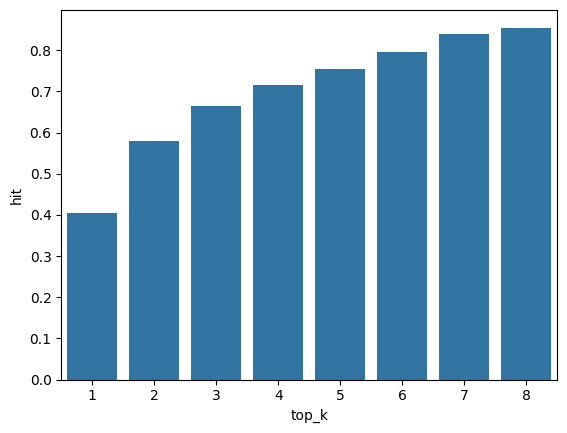

In [13]:
import seaborn as sns
temp = hit_state_df.groupby("top_k")['hit'].mean().reset_index()
print(temp)
sns.barplot(x="top_k", y='hit', data=temp)

## 问答

In [ ]:
## LCEL表达式
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    model="gpt-4o-mini",
    temperature=0.85
)


def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)

prompt = PromptTemplate.from_template(
    template="""
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{context}
<<<</context>>>

问题：{question}
请回答：
"""
)


retriever = vector_db.as_retriever(search_kwargs={'k': 4})

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
for chunk in rag_chain.stream("2023年10月美国ISM制造业PMI指数较上月有何变化？"):
    print(chunk, end="", flush=True)

2023年10月，美国ISM制造业PMI指数较上月大幅下降2.3个百分点。

In [10]:
## 流程拆解

def rag(query, n_chunks=5):
    prompt_tmpl = """
    你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
    你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
    回答保持简洁，不必重复问题，不要要添加描述性解释和与答案无关的任何内容。
    已知信息：
    <<<<context>>>
    docs
    <<<</context>>>

    问题：question
    请回答：
    """.strip()
    chunks = retrieve(vector_db, query, k=n_chunks)
    prompt = prompt_tmpl.replace('docs', '\n\n'.join([doc.page_content for doc in chunks])).replace('question', query)
    return llm.invoke(prompt).content, '\n\n'.join(doc.page_content for doc in chunks)

prediction_df = qa_df.iloc[:10]

answer_dict = {}
for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
    uuid = row["uuid"]
    question = row["question"]
    answer, context = rag(question, n_chunks=4)
    answer_dict[question] = {
        'uuid': uuid,
        'ref_answer': row['answer'],
        'gen_answer': answer,
        'context': context
    }

prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
prediction_df.loc[:, 'context'] = prediction_df['question'].apply(lambda q: answer_dict[q]['context'])
prediction_df.head(5)

100%|██████████| 10/10 [00:45<00:00,  4.57s/it]
/var/folders/hf/sr_hnkdx0hngrzhq36gsqvdw0000gn/T/ipykernel_19815/1577244529.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])


,question,context,answer,uuid,gen_answer
0,2023年全球经济增长的主要特点是什么？,图 1：全球GDP增速（%）\n资料来源：IMF，中国银行研究院\n分区域看，全球经济复苏不...,2023年全球经济增长动力持续回落，发达经济体增速明显放缓，而新兴经济体整体表现稳定。,35e5de15-d070-498f-8ffc-447971614d05,2023年全球经济增长的主要特点是发达经济体增速放缓，新兴经济体增速与2022年大致持平，但...
1,2024年全球经济复苏的预期是什么？,\n\n率政策。\n二是各国经济走势将进一步分化。相较于新兴市场和发展中经济体，发达\n经济...,预计全球经济复苏将依旧疲软，主要经济体的增长态势和货币政策走势将进一步分化。,35e5de15-d070-498f-8ffc-447971614d05,2024年全球经济复苏预期为疲软，增速约在2.5%左右，较2023年下降0.2个百分点，复苏...
2,2023年全球股市的表现如何？,\n\n展望2024 年，全球股票市场走势将呈现以下特征。\n1.美国股票市场上行空间有限，...,全球股市表现总体好于预期，但存在明显的区域分化。,35e5de15-d070-498f-8ffc-447971614d05,截至2023年11月15日，全球股市表现总体好于预期，MSCI全球指数涨幅达13.0%。发达...
3,高利率环境对债券市场有什么影响？,\n\n体国债收益率出现较大幅度下跌。当前，国债收益率大幅波动成为全球金融市\n场重要风险点...,高利率环境抑制债券融资需求，并导致债券违约风险持续上升。,35e5de15-d070-498f-8ffc-447971614d05,高利率环境抑制了债券融资需求，导致债券市场融资规模下降。同时，国债收益率维持高位，全球债券违...
4,预计2024年美国房地产市场将受到什么影响？,\n\n响 2024 年美国经济走势的重要因素。2023 年美国通胀已明显放缓，受基期效\n...,高利率和高债务将对美国房地产市场的脆弱性产生影响。,35e5de15-d070-498f-8ffc-447971614d05,预计2024年美国房地产市场将受到以下影响：\n\n1. 通胀回落至2%目标将遇阻，可能导致...
